#Imports

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix
from tqdm import tqdm

#Confusion Matrix

In [36]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    blanks = ['' for i in range(cf.size)]
    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks
    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks
    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks
    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))
        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""
    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')
    if xyticks==False:
        categories=False
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    if title:
        plt.title(title)

#Loading the CIFAR10 Dataset

In [42]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
channels = images[0].shape[0]

print(images.shape) # (Batch_size, Number_of_Channels, Height, Width) -> BCHW : That is how Pytorch gets the input.
print(labels)

torch.Size([16, 3, 32, 32])
tensor([2, 3, 8, 3, 2, 6, 2, 9, 5, 5, 4, 0, 5, 5, 1, 1])


#My CNN-based Model

In [70]:
class My_CNN_for_CIFAR10(nn.Module):

    def __init__(self, input_channels, channels_one, kernel_one, channels_two, kernel_two,
                 channels_three, kernel_three, max_pool_size, fc_one, fc_two, fc_three=10):

        super().__init__()

        self.input_channels = input_channels
        self.channels_one = channels_one
        self.kernel_one = kernel_one
        self.channels_two = channels_two
        self.kernel_two = kernel_two
        self.channels_three = channels_three
        self.kernel_three = kernel_three
        self.max_pool_size = max_pool_size
        self.fc_one = fc_one
        self.fc_two = fc_two
        self.fc_three = fc_three
        self.final_width_before_fcs = 5
        self.padding_for_last_cnv = (self.kernel_three - 1) // 2 # Equivalent to Padding='same' in Keras.

        self.cnv1 = nn.Conv2d(in_channels=self.input_channels, out_channels=self.channels_one, kernel_size=self.kernel_one)
        self.cnv2 = nn.Conv2d(in_channels=self.channels_one, out_channels=self.channels_two, kernel_size=self.kernel_two)
        self.cnv3 = nn.Conv2d(in_channels=self.channels_two, out_channels=self.channels_three, kernel_size=self.kernel_three, padding=self.padding_for_last_cnv)
        self.pool = nn.MaxPool2d(self.max_pool_size)
        
        self.fc1 = nn.Linear(self.channels_three*self.final_width_before_fcs*self.final_width_before_fcs, self.fc_one)
        self.fc2 = nn.Linear(self.fc_one, self.fc_two)
        self.fc3 = nn.Linear(self.fc_two, self.fc_three)

    def forward(self, x):

        x = self.pool(F.relu(self.cnv1(x))) # 3*32*32 -> 6*28*28 -> 6*14*14
        x = self.pool(F.relu(self.cnv2(x))) # 6*14*14 -> 12*10*10 -> 12*5*5
        x = F.relu(self.cnv3(x)) # 12*5*5 -> 16*5*5

        x = torch.flatten(x, 1) # 16*5*5 -> 400

        x = F.relu(self.fc1(x)) # 400 -> 120
        x = F.relu(self.fc2(x)) # 120 -> 84
        x = self.fc3(x) # 84 -> 10

        return x

        #return F.softmax(x, dim=1) # (10, )

#Instantiating the Model

In [77]:
lr = 0.01
epochs = 100

model = My_CNN_for_CIFAR10(input_channels=channels, channels_one=6, kernel_one=5, channels_two=12, kernel_two=5,
                           channels_three=16, kernel_three=5, max_pool_size=(2, 2), fc_one=120, fc_two=84)

model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [78]:
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 12, 10, 10]           1,812
         MaxPool2d-4             [-1, 12, 5, 5]               0
            Conv2d-5             [-1, 16, 5, 5]           4,816
            Linear-6                  [-1, 120]          48,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 66,218
Trainable params: 66,218
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.25
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


#Training

In [79]:
#Running this cell will take almost 1 hour!
model.train()

losses = []
for epoch in tqdm(range(epochs)):

    LOSS = 0.0

    for i, data in enumerate(trainloader):

        X, Y = data
        X, Y = X.cuda(), Y.cuda()

        optimizer.zero_grad()

        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        LOSS += loss.item()
        if i % 2000 == 1999:
            print(f'Epoch:{epoch + 1} -> Loss:{LOSS / 2000:.3f}')
            losses.append(LOSS/2000)
            LOSS = 0.0

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:1 -> Loss:2.303


  1%|          | 1/100 [00:31<52:08, 31.60s/it]

Epoch:2 -> Loss:2.017


  2%|▏         | 2/100 [01:02<50:47, 31.09s/it]

Epoch:3 -> Loss:1.670


  3%|▎         | 3/100 [01:33<50:14, 31.08s/it]

Epoch:4 -> Loss:1.499


  4%|▍         | 4/100 [02:04<49:40, 31.04s/it]

Epoch:5 -> Loss:1.383


  5%|▌         | 5/100 [02:35<49:18, 31.14s/it]

Epoch:6 -> Loss:1.290


  6%|▌         | 6/100 [03:06<48:35, 31.02s/it]

Epoch:7 -> Loss:1.219


  7%|▋         | 7/100 [03:37<48:01, 30.98s/it]

Epoch:8 -> Loss:1.149


  8%|▊         | 8/100 [04:08<47:33, 31.02s/it]

Epoch:9 -> Loss:1.101


  9%|▉         | 9/100 [04:39<47:06, 31.06s/it]

Epoch:10 -> Loss:1.050


 10%|█         | 10/100 [05:10<46:31, 31.02s/it]

Epoch:11 -> Loss:1.014


 11%|█         | 11/100 [05:41<46:07, 31.09s/it]

Epoch:12 -> Loss:0.972


 12%|█▏        | 12/100 [06:12<45:33, 31.06s/it]

Epoch:13 -> Loss:0.936


 13%|█▎        | 13/100 [06:44<45:07, 31.12s/it]

Epoch:14 -> Loss:0.910


 14%|█▍        | 14/100 [07:14<44:29, 31.04s/it]

Epoch:15 -> Loss:0.870


 15%|█▌        | 15/100 [07:45<43:55, 31.01s/it]

Epoch:16 -> Loss:0.850


 16%|█▌        | 16/100 [08:17<43:29, 31.06s/it]

Epoch:17 -> Loss:0.818


 17%|█▋        | 17/100 [08:48<43:03, 31.13s/it]

Epoch:18 -> Loss:0.795


 18%|█▊        | 18/100 [09:19<42:30, 31.10s/it]

Epoch:19 -> Loss:0.764


 19%|█▉        | 19/100 [09:50<41:53, 31.04s/it]

Epoch:20 -> Loss:0.740


 20%|██        | 20/100 [10:21<41:37, 31.21s/it]

Epoch:21 -> Loss:0.723


 21%|██        | 21/100 [10:53<41:18, 31.38s/it]

Epoch:22 -> Loss:0.697


 22%|██▏       | 22/100 [11:25<40:53, 31.46s/it]

Epoch:23 -> Loss:0.680


 23%|██▎       | 23/100 [11:56<40:20, 31.44s/it]

Epoch:24 -> Loss:0.663


 24%|██▍       | 24/100 [12:27<39:42, 31.34s/it]

Epoch:25 -> Loss:0.640


 25%|██▌       | 25/100 [12:59<39:12, 31.37s/it]

Epoch:26 -> Loss:0.622


 26%|██▌       | 26/100 [13:30<38:41, 31.37s/it]

Epoch:27 -> Loss:0.599


 27%|██▋       | 27/100 [14:01<38:06, 31.33s/it]

Epoch:28 -> Loss:0.579


 28%|██▊       | 28/100 [14:33<37:37, 31.36s/it]

Epoch:29 -> Loss:0.573


 29%|██▉       | 29/100 [15:04<37:10, 31.41s/it]

Epoch:30 -> Loss:0.552


 30%|███       | 30/100 [15:36<36:36, 31.38s/it]

Epoch:31 -> Loss:0.536


 31%|███       | 31/100 [16:07<35:58, 31.28s/it]

Epoch:32 -> Loss:0.522


 32%|███▏      | 32/100 [16:38<35:21, 31.19s/it]

Epoch:33 -> Loss:0.501


 33%|███▎      | 33/100 [17:09<34:43, 31.10s/it]

Epoch:34 -> Loss:0.495


 34%|███▍      | 34/100 [17:40<34:11, 31.09s/it]

Epoch:35 -> Loss:0.482


 35%|███▌      | 35/100 [18:11<33:44, 31.14s/it]

Epoch:36 -> Loss:0.467


 36%|███▌      | 36/100 [18:42<33:10, 31.09s/it]

Epoch:37 -> Loss:0.455


 37%|███▋      | 37/100 [19:13<32:40, 31.12s/it]

Epoch:38 -> Loss:0.442


 38%|███▊      | 38/100 [19:44<32:11, 31.15s/it]

Epoch:39 -> Loss:0.436


 39%|███▉      | 39/100 [20:15<31:38, 31.13s/it]

Epoch:40 -> Loss:0.418


 40%|████      | 40/100 [20:46<31:08, 31.14s/it]

Epoch:41 -> Loss:0.420


 41%|████      | 41/100 [21:18<30:42, 31.22s/it]

Epoch:42 -> Loss:0.408


 42%|████▏     | 42/100 [21:49<30:06, 31.15s/it]

Epoch:43 -> Loss:0.402


 43%|████▎     | 43/100 [22:20<29:39, 31.22s/it]

Epoch:44 -> Loss:0.391


 44%|████▍     | 44/100 [22:51<29:07, 31.21s/it]

Epoch:45 -> Loss:0.381


 45%|████▌     | 45/100 [23:22<28:30, 31.11s/it]

Epoch:46 -> Loss:0.372


 46%|████▌     | 46/100 [23:53<27:56, 31.04s/it]

Epoch:47 -> Loss:0.379


 47%|████▋     | 47/100 [24:24<27:26, 31.06s/it]

Epoch:48 -> Loss:0.362


 48%|████▊     | 48/100 [24:55<26:52, 31.01s/it]

Epoch:49 -> Loss:0.370


 49%|████▉     | 49/100 [25:26<26:23, 31.06s/it]

Epoch:50 -> Loss:0.354


 50%|█████     | 50/100 [25:57<25:52, 31.05s/it]

Epoch:51 -> Loss:0.362


 51%|█████     | 51/100 [26:29<25:29, 31.21s/it]

Epoch:52 -> Loss:0.351


 52%|█████▏    | 52/100 [27:00<25:01, 31.28s/it]

Epoch:53 -> Loss:0.348


 53%|█████▎    | 53/100 [27:32<24:30, 31.30s/it]

Epoch:54 -> Loss:0.335


 54%|█████▍    | 54/100 [28:03<24:03, 31.39s/it]

Epoch:55 -> Loss:0.347


 55%|█████▌    | 55/100 [28:35<23:34, 31.43s/it]

Epoch:56 -> Loss:0.329


 56%|█████▌    | 56/100 [29:06<23:02, 31.43s/it]

Epoch:57 -> Loss:0.332


 57%|█████▋    | 57/100 [29:38<22:32, 31.46s/it]

Epoch:58 -> Loss:0.321


 58%|█████▊    | 58/100 [30:09<22:01, 31.48s/it]

Epoch:59 -> Loss:0.323


 59%|█████▉    | 59/100 [30:40<21:26, 31.38s/it]

Epoch:60 -> Loss:0.322


 60%|██████    | 60/100 [31:12<20:51, 31.29s/it]

Epoch:61 -> Loss:0.316


 61%|██████    | 61/100 [31:43<20:26, 31.44s/it]

Epoch:62 -> Loss:0.310


 62%|██████▏   | 62/100 [32:15<19:55, 31.46s/it]

Epoch:63 -> Loss:0.315


 63%|██████▎   | 63/100 [32:46<19:20, 31.37s/it]

Epoch:64 -> Loss:0.298


 64%|██████▍   | 64/100 [33:17<18:45, 31.27s/it]

Epoch:65 -> Loss:0.301


 65%|██████▌   | 65/100 [33:48<18:10, 31.15s/it]

Epoch:66 -> Loss:0.307


 66%|██████▌   | 66/100 [34:19<17:38, 31.15s/it]

Epoch:67 -> Loss:0.301


 67%|██████▋   | 67/100 [34:50<17:08, 31.17s/it]

Epoch:68 -> Loss:0.297


 68%|██████▊   | 68/100 [35:21<16:36, 31.14s/it]

Epoch:69 -> Loss:0.295


 69%|██████▉   | 69/100 [35:53<16:05, 31.14s/it]

Epoch:70 -> Loss:0.308


 70%|███████   | 70/100 [36:23<15:32, 31.09s/it]

Epoch:71 -> Loss:0.293


 71%|███████   | 71/100 [36:55<15:04, 31.20s/it]

Epoch:72 -> Loss:0.293


 72%|███████▏  | 72/100 [37:27<14:37, 31.34s/it]

Epoch:73 -> Loss:0.277


 73%|███████▎  | 73/100 [37:57<14:01, 31.18s/it]

Epoch:74 -> Loss:0.296


 74%|███████▍  | 74/100 [38:28<13:28, 31.09s/it]

Epoch:75 -> Loss:0.278


 75%|███████▌  | 75/100 [38:59<12:56, 31.07s/it]

Epoch:76 -> Loss:0.272


 76%|███████▌  | 76/100 [39:31<12:27, 31.15s/it]

Epoch:77 -> Loss:0.292


 77%|███████▋  | 77/100 [40:02<11:58, 31.22s/it]

Epoch:78 -> Loss:0.285


 78%|███████▊  | 78/100 [40:34<11:29, 31.33s/it]

Epoch:79 -> Loss:0.300


 79%|███████▉  | 79/100 [41:05<10:57, 31.32s/it]

Epoch:80 -> Loss:0.278


 80%|████████  | 80/100 [41:36<10:25, 31.29s/it]

Epoch:81 -> Loss:0.290


 81%|████████  | 81/100 [42:08<09:56, 31.39s/it]

Epoch:82 -> Loss:0.297


 82%|████████▏ | 82/100 [42:39<09:24, 31.34s/it]

Epoch:83 -> Loss:0.288


 83%|████████▎ | 83/100 [43:10<08:51, 31.28s/it]

Epoch:84 -> Loss:0.266


 84%|████████▍ | 84/100 [43:41<08:19, 31.24s/it]

Epoch:85 -> Loss:0.261


 85%|████████▌ | 85/100 [44:13<07:48, 31.24s/it]

Epoch:86 -> Loss:0.278


 86%|████████▌ | 86/100 [44:44<07:17, 31.23s/it]

Epoch:87 -> Loss:0.275


 87%|████████▋ | 87/100 [45:15<06:46, 31.26s/it]

Epoch:88 -> Loss:0.273


 88%|████████▊ | 88/100 [45:47<06:16, 31.35s/it]

Epoch:89 -> Loss:0.280


 89%|████████▉ | 89/100 [46:18<05:43, 31.27s/it]

Epoch:90 -> Loss:0.273


 90%|█████████ | 90/100 [46:49<05:12, 31.23s/it]

Epoch:91 -> Loss:0.274


 91%|█████████ | 91/100 [47:20<04:41, 31.25s/it]

Epoch:92 -> Loss:0.274


 92%|█████████▏| 92/100 [47:51<04:09, 31.21s/it]

Epoch:93 -> Loss:0.290


 93%|█████████▎| 93/100 [48:22<03:38, 31.16s/it]

Epoch:94 -> Loss:0.277


 94%|█████████▍| 94/100 [48:54<03:07, 31.20s/it]

Epoch:95 -> Loss:0.264


 95%|█████████▌| 95/100 [49:25<02:36, 31.31s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f51d836a320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch:96 -> Loss:0.275


 96%|█████████▌| 96/100 [49:57<02:05, 31.34s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f51d836a320>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f51d836a320>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._p

Epoch:97 -> Loss:0.267


 97%|█████████▋| 97/100 [50:28<01:34, 31.39s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f51d836a320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f51d836a320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pyt

Epoch:98 -> Loss:0.272


 98%|█████████▊| 98/100 [51:00<01:03, 31.50s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f51d836a320>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f51d836a320>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._p

Epoch:99 -> Loss:0.278


 99%|█████████▉| 99/100 [51:31<00:31, 31.47s/it]

Epoch:100 -> Loss:0.277


100%|██████████| 100/100 [52:03<00:00, 31.23s/it]


#Testing

In [191]:
model.eval()

y_real = []
y_preds = []

with torch.no_grad():

  for i, data in enumerate(testloader):

    X, Y = data
    X, Y = X.cuda(), Y.cuda()

    y_pred = model(X)
    arg = np.argmax(y_pred.cpu())
    y_preds.append(y_pred)
    y_real.append(Y.cpu())

y_p = np.argmax(F.softmax(y_preds[0].cpu(), dim=1), axis=1)

#Confusion Matrix

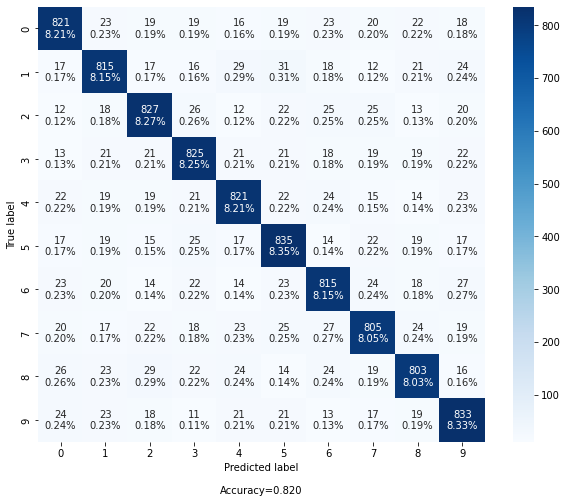

In [201]:
cf_matrix = confusion_matrix(y_real[0], y_p)
make_confusion_matrix(cf_matrix, figsize=(10,8), cbar=True)